# Forecasting Daily Load Values in Tetouan

#### Goal
Forecast the daily electricity consumption in Tetouan, Morocco.

The data is a text file consisting of comma separated values, and can be found from UC Irvine's [Machine Learning Repository](https://archive.ics.uci.edu/dataset/849/power+consumption+of+tetouan+city).

Each record contains 6 features and three targets:
 1. [feature] Datetime
 2. [feature] Temperature
 3. [feature] Humidity
 4. [feature] Wind Speed
 5. [feature] General Diffuse Flows
 6. [feature] Diffuse Flows
 7. [target] Zone 1 Power Consumption
 8. [target] Zone 2 Power Consumption
 9. [target] Zone 3 Power Consumption

There is a total of 52416 records. This represents 1 entire year of data, where the load values are sampled in 10 minute intervals. It is worth noting that Tetouan is a city in Morocco, so any modifications of the `DateTime` feature should take into account that Muslim countries do not have the same Sunda/Monday paradigm that Christian countries do, and that there is a different holiday schedule.

Based on an entry in the [CoderzColumn](https://coderzcolumn.com/tutorials/artificial-intelligence/pytorch-lstm-networks-for-time-series-regression-tasks) Data Science / AI blog

#### Methodology

The forecasting approach will consist of applying a **Many-to-One Long-Short Term Memory (LSTM)** neural network, as implemented in the PyTorch module. The `many` refers to the fact that several features will be used when constructing the prediction of a `one` value, which in this case will be `Zone 1 Power Consumption`.

#### Observations

The LSTM block performs well detecting and forecasting the periodicity of the data. The performance on forecasting the absolute magnitures at the peaks and troughs is uniformly bad, however. This approach would not work for common load profile problems such as forecasting monthly peaks. In particular, the forecasted magnitudes in the trough regions are extremely bad, as they do not even capture the right curvature.

In [92]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
import gc
from torch.optim import Adam
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3070 Laptop GPU'

In [73]:
data_df = pd.read_csv("./data/tetuan_power.csv")
data_df["DateTime"] = pd.to_datetime(data_df["DateTime"])
data_df = data_df.set_index('DateTime')
data_df.columns = [col.strip() for col in data_df.columns]
print("Columns : {}".format(data_df.columns.values.tolist()))
print("Dataset Shape : {}".format(data_df.shape))
data_df.tail()

Columns : ['Temperature', 'Humidity', 'Wind Speed', 'general diffuse flows', 'diffuse flows', 'Zone 1 Power Consumption', 'Zone 2  Power Consumption', 'Zone 3  Power Consumption']
Dataset Shape : (52416, 8)


,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
DateTime,,,,,,,,
2017-12-30 23:10:00,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212
2017-12-30 23:20:00,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152
2017-12-30 23:30:00,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259
2017-12-30 23:40:00,6.758,73.0,0.080,0.066,0.089,28958.17490,24692.23688,13512.60504
2017-12-30 23:50:00,6.580,74.1,0.081,0.062,0.111,28349.80989,24055.23167,13345.49820


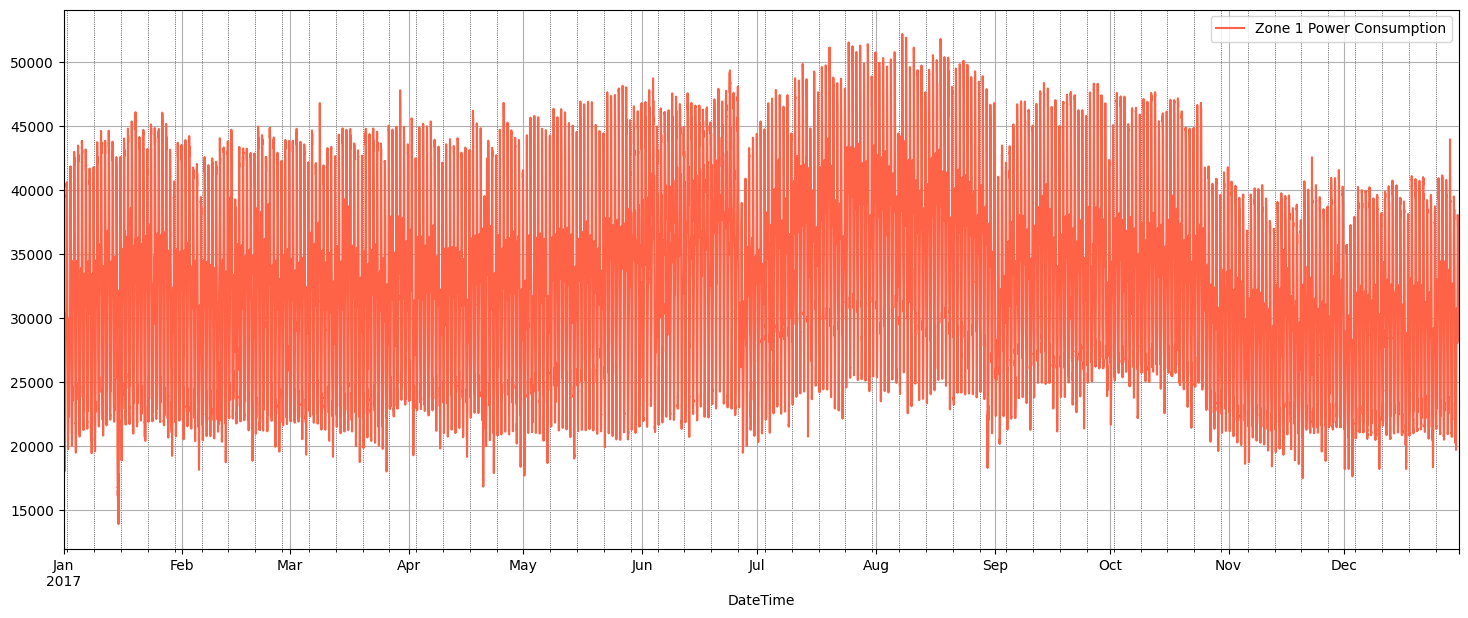

In [74]:
data_df.loc["2017-1":"2017-12"].plot(
    y="Zone 1 Power Consumption",
    figsize=(18, 7),
    color="tomato",
    grid=True
)
plt.grid(
    which="minor", 
    linestyle=":", 
    linewidth="0.5", 
    color="black"
)

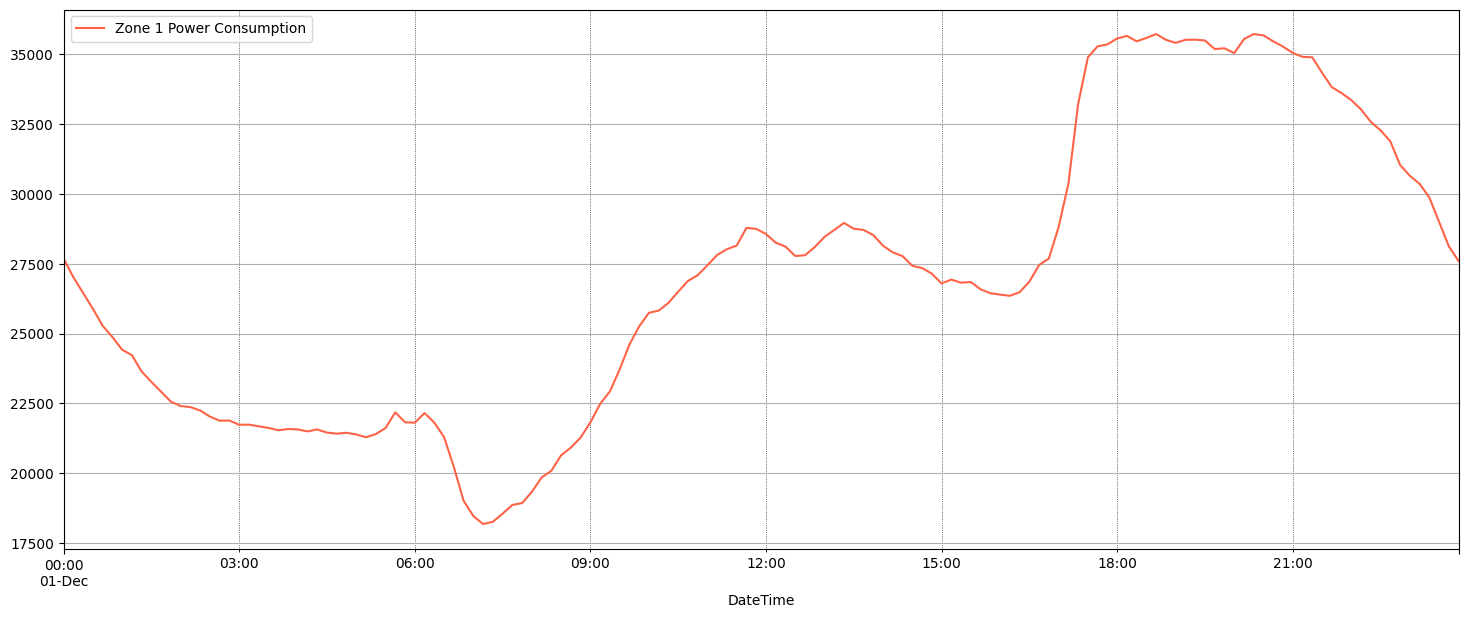

In [75]:
data_df.loc["2017-12-1"].plot(
    y="Zone 1 Power Consumption", 
    figsize=(18, 7), 
    color="tomato", 
    grid=True
)
plt.grid(
    which="minor", 
    linestyle=":", 
    linewidth="0.5", 
    color="black"
)

In [125]:
feature_cols = ['Temperature', 'Humidity', 'Wind Speed', 'general diffuse flows', 'diffuse flows']
target_col = 'Zone 1 Power Consumption'

X = data_df[feature_cols].values
Y = data_df[target_col].values

n_features = X.shape[1]
lookback = 30 ## 5 hours lookback to make prediction

X_organized, Y_organized = [], []
for i in range(0, X.shape[0]-lookback, 1):
    X_organized.append(X[i:i+lookback])
    Y_organized.append(Y[i+lookback])

X_organized, Y_organized = np.array(X_organized), np.array(Y_organized)
X_organized, Y_organized = torch.tensor(X_organized, dtype=torch.float32), torch.tensor(Y_organized, dtype=torch.float32)
X_train, Y_train, X_test, Y_test = X_organized[:50000], Y_organized[:50000], X_organized[50000:], Y_organized[50000:]

z-score normalization:

In [126]:
mean, std = Y_train.mean(), Y_train.std()

print("Mean : {:.2f}, Standard Deviation : {:.2f}".format(mean, std))
Y_train_scaled, Y_test_scaled = (Y_train - mean)/std , (Y_test-mean)/std

Y_train_scaled.min(), Y_train_scaled.max(), Y_test_scaled.min(), Y_test_scaled.max()

Mean : 32492.51, Standard Deviation : 7137.58


(tensor(-2.6055), tensor(2.7617), tensor(-2.0030), tensor(1.6084))

In [127]:
import gc
del X, Y
gc.collect()

7733

In [128]:
train_dataset = TensorDataset(X_train, Y_train_scaled)
test_dataset  = TensorDataset(X_test,  Y_test_scaled)

train_loader = DataLoader(train_dataset, shuffle=False, batch_size=32)
test_loader  = DataLoader(test_dataset,  shuffle=False, batch_size=32)

In [129]:
hidden_dim = 128
n_layers=2

class LSTMRegressor(
        nn.Module
    ):
    def __init__(self):
        super(
            LSTMRegressor,
            self
        ).__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True
        )
        self.linear = nn.Linear(
            hidden_dim,
            1
        )
    def forward(self, X_batch):
        hidden, carry = torch.randn(n_layers, len(X_batch), hidden_dim), torch.randn(n_layers, len(X_batch), hidden_dim)
        output, (hidden, carry) = self.lstm(X_batch, (hidden, carry))
        return self.linear(output[:,-1])

In [130]:
lstm_regressor = LSTMRegressor()

In [131]:
for layer in lstm_regressor.children():
    print("Layer : {}".format(layer))
    print("Parameters : ")
    for param in layer.parameters():
        print(param.shape)
    print()

Layer : LSTM(5, 128, num_layers=2, batch_first=True)
Parameters : 
torch.Size([512, 5])
torch.Size([512, 128])
torch.Size([512])
torch.Size([512])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512])
torch.Size([512])

Layer : Linear(in_features=128, out_features=1, bias=True)
Parameters : 
torch.Size([1, 128])
torch.Size([1])



In [132]:
def CalcValLoss(model, loss_fn, val_loader):
    with torch.no_grad():
        losses = []
        for X, Y in val_loader:
            preds = model(X)
            loss = loss_fn(preds.ravel(), Y)
            losses.append(loss.item())
        print("Valid Loss : {:.3f}".format(torch.tensor(losses).mean()))

def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    for i in range(1, epochs+1):
        losses = []
        for X, Y in tqdm(train_loader):
            Y_preds = model(X)

            loss = loss_fn(Y_preds.ravel(), Y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
        CalcValLoss(model, loss_fn, val_loader)

In [133]:
epochs = 20
learning_rate = 1e-3

loss_fn = nn.MSELoss()
lstm_regressor = LSTMRegressor()
optimizer = Adam(lstm_regressor.parameters(), lr=learning_rate)

TrainModel(lstm_regressor, loss_fn, optimizer, train_loader, test_loader, epochs)

100%|██████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:42<00:00, 37.16it/s]


Train Loss : 0.171
Valid Loss : 0.098


100%|██████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.89it/s]


Train Loss : 0.141
Valid Loss : 0.095


100%|██████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:44<00:00, 35.07it/s]


Train Loss : 0.135
Valid Loss : 0.095


100%|██████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:45<00:00, 34.43it/s]


Train Loss : 0.130
Valid Loss : 0.085


100%|██████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:44<00:00, 34.97it/s]


Train Loss : 0.128
Valid Loss : 0.083


100%|██████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:47<00:00, 33.00it/s]


Train Loss : 0.124
Valid Loss : 0.093


100%|██████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:44<00:00, 34.97it/s]


Train Loss : 0.124
Valid Loss : 0.085


100%|██████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:44<00:00, 35.38it/s]


Train Loss : 0.120
Valid Loss : 0.082


100%|██████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:46<00:00, 33.49it/s]


Train Loss : 0.121
Valid Loss : 0.078


100%|██████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:45<00:00, 34.00it/s]


Train Loss : 0.120
Valid Loss : 0.078


100%|██████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:48<00:00, 32.42it/s]


Train Loss : 0.120
Valid Loss : 0.078


100%|██████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:47<00:00, 32.62it/s]


Train Loss : 0.119
Valid Loss : 0.078


100%|██████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:45<00:00, 34.25it/s]


Train Loss : 0.118
Valid Loss : 0.074


100%|██████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:47<00:00, 32.71it/s]


Train Loss : 0.118
Valid Loss : 0.078


100%|██████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:46<00:00, 33.47it/s]


Train Loss : 0.119
Valid Loss : 0.077


100%|██████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:47<00:00, 32.98it/s]


Train Loss : 0.117
Valid Loss : 0.075


100%|██████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:49<00:00, 31.53it/s]


Train Loss : 0.115
Valid Loss : 0.072


100%|██████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:50<00:00, 30.98it/s]


Train Loss : 0.118
Valid Loss : 0.078


100%|██████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:51<00:00, 30.24it/s]


Train Loss : 0.117
Valid Loss : 0.076


100%|██████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:49<00:00, 31.78it/s]


Train Loss : 0.116
Valid Loss : 0.075


In [134]:
test_preds = lstm_regressor(X_test) ## Make Predictions on test dataset
test_preds  = (test_preds*std) + mean

test_preds[:5]

tensor([[29358.5605],
        [29556.8008],
        [30000.2969],
        [30275.6465],
        [30773.9414]], grad_fn=<SliceBackward0>)

In [135]:
print(
    "Test  MSE : {:.2f}".format(mean_squared_error(test_preds.detach().numpy().squeeze(),Y_test.detach().numpy()))
)
print(
    "Test  R^2 Score : {:.2f}".format(r2_score(test_preds.detach().numpy().squeeze(), Y_test.detach().numpy()))
)

Test  MSE : 3786569.25
Test  R^2 Score : 0.88


In [136]:
data_df_final = data_df[50000:].copy()

data_df_final["Zone 1 Power Consumption Prediction"] = [None]*lookback + test_preds.detach().numpy().squeeze().tolist()

data_df_final.tail()

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption,Zone 1 Power Consumption Prediction
DateTime,,,,,,,,,
2017-12-30 23:10:00,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212,31549.150391
2017-12-30 23:20:00,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152,31195.537109
2017-12-30 23:30:00,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259,29408.470703
2017-12-30 23:40:00,6.758,73.0,0.080,0.066,0.089,28958.17490,24692.23688,13512.60504,23132.699219
2017-12-30 23:50:00,6.580,74.1,0.081,0.062,0.111,28349.80989,24055.23167,13345.49820,23020.679688


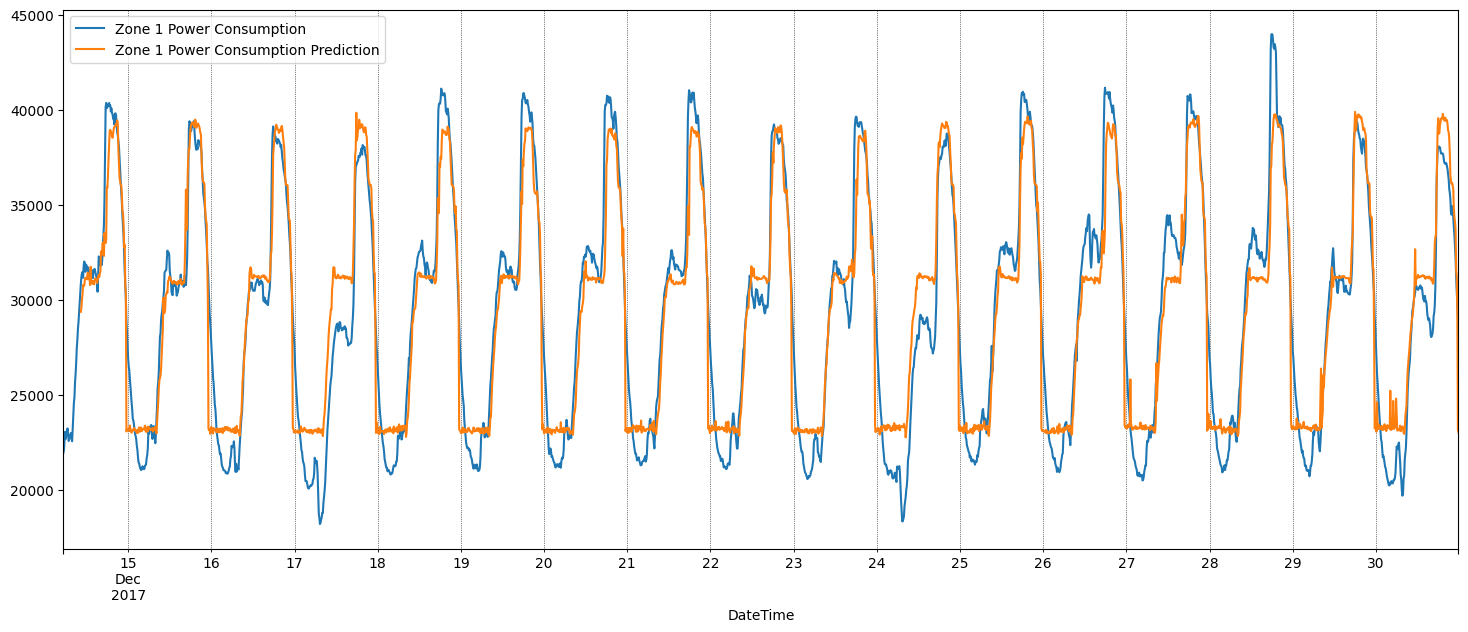

In [137]:
data_df_final.plot(
    y=["Zone 1 Power Consumption", "Zone 1 Power Consumption Prediction"],
    figsize=(18,7)
)
plt.grid(
    which='minor',
    linestyle=':',
    linewidth='0.5',
    color='black'
);